<a href="https://colab.research.google.com/github/majeedk526/Advanced-Line-follower/blob/master/pyro_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from: https://pyro.ai/examples/intro_part_i.html

In [0]:
# ! pip install pyro-ppl

In [0]:
import torch
import pyro

pyro.set_rng_seed(101)

In [0]:
normal = torch.distributions.Normal(loc=0, scale=1)
x = normal.rsample()
print("sample ", x)
print("log_prob", normal.log_prob(x))

sample  tensor(-1.3905)
log_prob tensor(-1.8857)


In [0]:
def weather():
  cloudy = torch.distributions.Bernoulli(0.3).sample()
  print("cloudy: ", cloudy)
  weather = "cloudy" if cloudy.item()==1.0 else "sunny"
  mean_temp = {"cloudy": 50, "sunny":75}[weather]
  scale_temp = {"cloudy": 10, "sunny": 15}[weather]
  temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
  
  return weather, temp.item()
  

  
print(weather())

cloudy:  tensor(1.)
('cloudy', 41.847618103027344)


In [0]:
def weather():
  cloudy = pyro.sample("cloudy", pyro.distributions.Bernoulli(0.3))
  print("cloudy: ", cloudy)
  weather = "cloudy" if cloudy.item()==1.0 else "sunny"
  mean_temp = {"cloudy": 50, "sunny":75}[weather]
  scale_temp = {"cloudy": 10, "sunny": 15}[weather]
  temp = pyro.sample("temp", pyro.distributions.Normal(mean_temp, scale_temp))
  
  return weather, temp.item()
  

print(weather())

cloudy:  tensor(1.)
('cloudy', 48.20433807373047)


## An Introduction to Inference in Pyro

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [5]:
def scale(guess):
  weight = pyro.sample('weight', dist.Normal(guess,1))
  measurement = pyro.sample('measurement',dist.Normal(weight,0.75))
  
  return measurement

print(scale(0.5))

tensor(-1.5019)


In [6]:
conditioned_scale = pyro.condition(scale, {"measurement": 7.3})
conditioned_scale(0.2)

7.3

In [0]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

a =  7.703725337982178
b =  0.6303155422210693


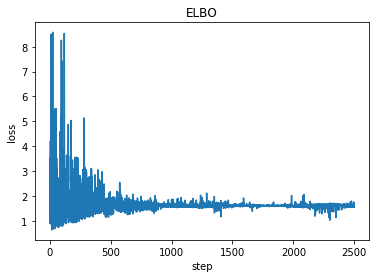

In [9]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned_scale,
    guide=scale_parametrized_guide,
    optim=pyro.optim.SGD({'lr':0.001, 'momentum':0.1}),
    loss=pyro.infer.Trace_ELBO()
)

losses, a, b = [], [], []
num_steps=2500
for t in range(num_steps):
  losses.append(svi.step(guess))
  a.append(pyro.param("a").item())
  b.append(pyro.param("b").item())
  
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())